In [32]:
import numpy as np
import pandas as pd
import orca
import os; os.chdir('../../')
import warnings; warnings.simplefilter('ignore')
from urbansim.utils import misc
import pandana as pdna
from collections import OrderedDict
    
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import LargeMultinomialLogitStep
import pandas as pd
import orca
# import os; os.chdir('/home/juan/activitysynth/')
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.neighbors import BallTree
%matplotlib inline

import pylogit as pl                   # For choice model estimation
from pylogit import nested_logit as nl # For nested logit convenience funcs
import math 
from collections import OrderedDict 

import pickle
import dill
import time

import urbansim_templates

from scripts import datasources, models, variables, utils

In [2]:
input_file_format = 'csv'
input_data_dir = '/home/data/spring_2019/base/'

formattable_fname_dict = {
    'parcels': 'parcels.{0}',
    'buildings': 'buildings.{0}',
    'jobs': 'jobs.{0}',
    'establishments': 'establishments.{0}',
    'households': 'households.{0}',
    'persons': 'persons.{0}',
    'rentals': 'craigslist.{0}',
    'units': 'units.{0}',
    'mtc_skims': 'mtc_skims.{0}',
    'beam_skims_raw': '30.skims-smart-23April2019-baseline.csv.gz',
    'beam_skims_imputed': 'beam_skims_imputed.{0}',
    # the following nodes and edges .csv's will be phased out and
    # replaced by travel model skims entirely
    'drive_nodes': 'drive_nodes.{0}',
    'drive_edges': 'drive_edges.{0}',
    'drive_access_vars': 'drive_net_vars.{0}',
    'walk_nodes': 'walk_nodes.{0}',
    'walk_edges': 'walk_edges.{0}',
    'walk_access_vars': 'walk_net_vars.{0}',
    'zones': 'zones.{0}',
    'zone_access_vars': 'zones_w_access_vars.{0}',
}

def format_fname_dict(formattable_fname_dict, format='csv'):
    formatted_dict = {
        k: v.format('csv')
        for k, v in formattable_fname_dict.items()}
    return formatted_dict

input_fnames = format_fname_dict(
            formattable_fname_dict, input_file_format)

In [3]:
orca.add_injectable('input_file_format', input_file_format)
orca.add_injectable('input_data_dir', input_data_dir)
orca.add_injectable('input_fnames', input_fnames)
orca.add_injectable('store', None)

In [7]:
orca.run(['initialize_network_small']) 
orca.run([ 'initialize_network_walk']) 
orca.run(['initialize_imputed_skims']) 
orca.run(['skims_aggregations']) 

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.04 s
Total time to execute iteration 1 with iteration value None: 0.04 s
Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.47 s
Total time to execute iteration 1 with iteration value None: 0.47 s
Running step 'initialize_imputed_skims'
Time to execute step 'initialize_imputed_skims': 0.05 s
Total time to execute iteration 1 with iteration value None: 0.05 s
Running step 'skims_aggregations'
Time to execute step 'skims_aggregations': 0.00 s
Total time to execute iteration 1 with iteration value None: 0.00 s


In [5]:
orca.list_steps()

['auto_ownership',
 'WLCM_gen_tt',
 'TOD_choice',
 'primary_mode_choice',
 'WLCM',
 'initialize_imputed_skims',
 'skims_aggregations',
 'test_manual_registration',
 'initialize_network_small',
 'initialize_network_walk',
 'network_aggregations_small',
 'network_aggregations_walk',
 'network_aggregations_beam',
 'wlcm_simulate',
 'auto_ownership_simulate',
 'primary_mode_choice_simulate',
 'TOD_choice_simulate',
 'TOD_distribution_simulate',
 'generate_activity_plans',
 'SLCM_simulate',
 'TOD_school_arrival_simulate',
 'TOD_school_departure_simulate',
 'TOD_school_distribution_simulate',
 'SMC_simulate']

In [8]:
orca.run(['SLCM_simulate',
 'TOD_school_arrival_simulate',
 'TOD_school_departure_simulate',
 'TOD_school_distribution_simulate',
 'SMC_simulate'])

Running step 'SLCM_simulate'
Time to execute step 'SLCM_simulate': 507.38 s
Running step 'TOD_school_arrival_simulate'
Time to execute step 'TOD_school_arrival_simulate': 11.07 s
Running step 'TOD_school_departure_simulate'
Time to execute step 'TOD_school_departure_simulate': 10.92 s
Running step 'TOD_school_distribution_simulate'
Time to execute step 'TOD_school_distribution_simulate': 1.53 s
Running step 'SMC_simulate'
Time to execute step 'SMC_simulate': 133.43 s
Total time to execute iteration 1 with iteration value None: 664.34 s


In [14]:
persons = orca.get_table('persons').to_frame()
schools = orca.get_table('schools').to_frame()

# Validation SLCM

### Enrollment diff distribution

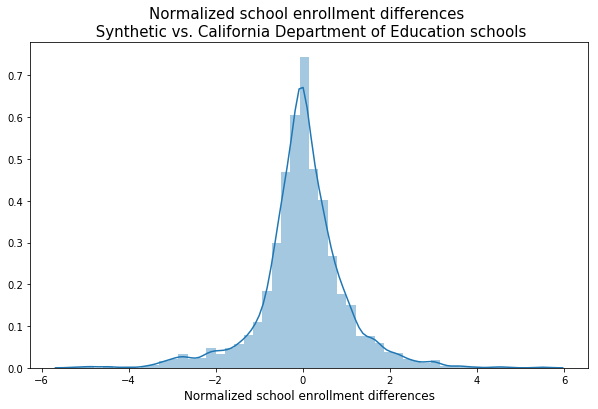

In [232]:
school_enrollment = persons.groupby('school_id').agg({'member_id':'count'})
list_schools = list(school_enrollment.index.astype(int)) # Schools that can be compared

#Enrollment difference between real 2018 vs simulated model
diff = school_enrollment.member_id - schools.loc[list_schools,:]['Total Enrollment']
diff.dropna(inplace = True)
normalized_diff =(diff-diff.mean())/diff.std()

#Plotting the difference 
plt.figure(figsize=(10, 6))
sns.distplot(normalized_diff)
plt.xlabel('Normalized school enrollment differences', fontsize=12)
plt.title('Normalized school enrollment differences \n Synthetic vs. California Department of Education schools', fontsize=15);

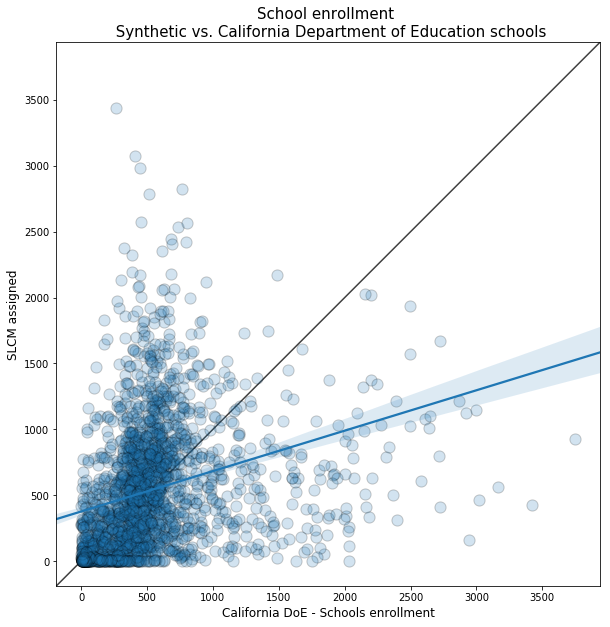

In [227]:
school_enrollment['real_enrollment'] = schools.loc[list_schools,:]['Total Enrollment']

fig, ax = plt.subplots(figsize=(10,10))
sns.regplot(
    'real_enrollment', 'member_id', school_enrollment,
    ax=ax, marker='.', fit_reg=True,
    scatter_kws={"s": 500, "edgecolor": 'k', "alpha": 0.2})

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_title('School enrollment \n Synthetic vs. California Department of Education schools', fontsize=15)
ax.set_ylabel('SLCM assigned', fontsize=12)
ax.set_xlabel('California DoE - Schools enrollment', fontsize=12);

### Distance to school distribution 

In [98]:
students = pd.read_csv('/home/juan/ual_model_workspace/spring-2019-models/notebooks-juan/students_with_school_id.csv')
skims = orca.get_table('beam_skims_imputed').dist.reset_index()

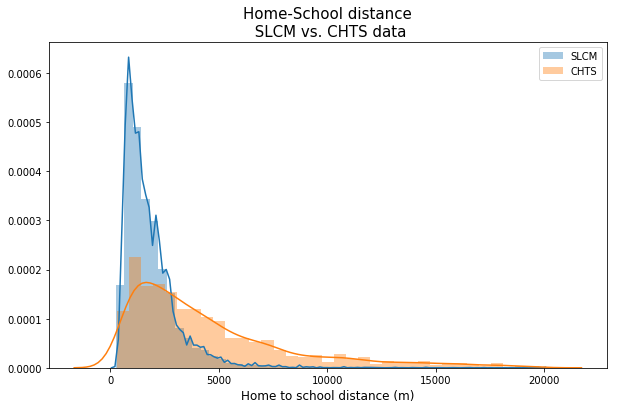

In [236]:
# Selecting important columns only 
students_data = students.loc[:,['school_id', 'zone_id_home']]
schools_data = schools.loc[:,['school_zone_id']]

#Merging students and school
dist_1 = pd.merge(students_data, schools_data, how = 'left', left_on = 'school_id', right_index = True)

#Merging home-school zone id with beam skims
chts_dist = pd.merge(dist_1, skims, how = 'left', 
                     left_on = ['zone_id_home','school_zone_id'], 
                     right_on= ['from_zone_id','to_zone_id']).dropna()

sim_dist = persons[['zone_id_home', 'zone_id_school']].dropna().merge(skims, how = 'left', 
                     left_on = ['zone_id_home','zone_id_school'], 
                     right_on= ['from_zone_id','to_zone_id'])

#Plotting distance distribution
plt.figure(figsize=(10, 6))
sns.distplot(sim_school[sim_school.dist <= 20000].dist, label= "SLCM")
sns.distplot(real_dist[real_dist.dist <= 20000].dist, label = "CHTS")
plt.xlabel('Home to school distance (m)', fontsize=12)
plt.title('Home-School distance\n SLCM vs. CHTS data', fontsize=15)

plt.legend();

### Private vs Public school market share

In [214]:
# Extracting school type
students_type = students.loc[:,['school_id']]
schools_type = schools.loc[:,['type']]

#Mergins school type to chts and simulated persons tables
chts_type = pd.merge(students_type, schools_type, how = 'left', left_on = 'school_id', right_index = True)

sim_type = pd.merge(persons.school_id.reset_index().dropna(), 
                    schools_type, 
                    how = 'left', left_on = 'school_id', right_index = True)

#CHTS public and private percentages
public_per = chts_type.type.value_counts()[0]/len(chts_type)
privat_per = chts_type.type.value_counts()[1]/len(chts_type)

#Simulkated public and private percentages
sim_public_per = sim_type.type.value_counts()[0]/len(sim_type)
sim_privat_per = sim_type.type.value_counts()[1]/len(sim_type)


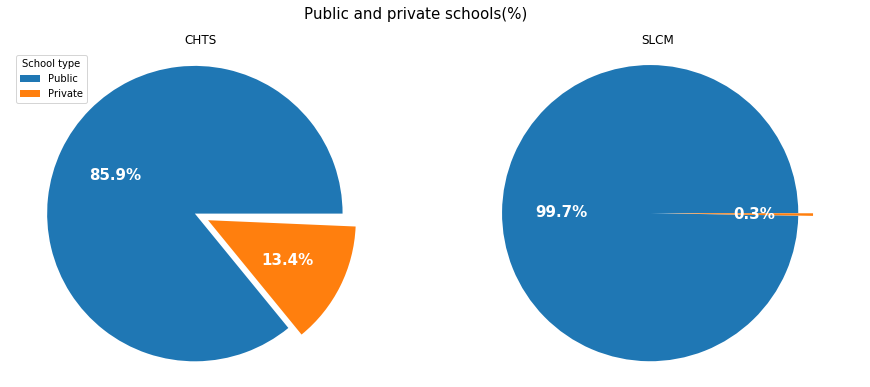

In [238]:
# Ploting public vs private enrollment
labels = 'Public', 'Private'

# Make figure and axes
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# CHTS data pie chart
wedges, texts, autotexts = axs[0].pie([public_per, privat_per], labels=labels, 
                                      autopct='%1.1f%%', explode=(0, 0.1),
                                      textprops=dict(color="w"))
axs[0].axis('equal') 
axs[0].set_title('CHTS')
axs[0].legend(wedges, ['Public', 'Private'],title="School type",loc="upper left")
plt.setp(autotexts, size=15, weight="bold")

# Simulated data pie chart
wedges, texts, autotexts = axs[1].pie([sim_public_per, sim_privat_per], labels=labels, 
                                      autopct='%1.1f%%', explode=(0, 0.1), 
                                      textprops=dict(color="w"))

axs[1].axis('equal')
axs[1].set_title('SLCM')
plt.setp(autotexts, size=15, weight="bold")

#Title
fig.suptitle('Public and private schools(%)',fontsize=15 )
plt.show()

## Time of the day

In [262]:
#CHTS data
#Loading data
trips = pd.read_csv('/home/emma/ual_model_workspace/spring-2019-models/notebooks-emma/HStrips_031219.csv', index_col = 0)

#select people who make both home-school and school-home trips:
tripsII = trips.groupby('HHPER').filter(lambda x: len(x) == 2)

#make sure all home-school trip rows are listed first
tripsIII = tripsII.sort_values(['HHPER','origin'])

#move school-home trip info up into home-school trip rows
tripsIII['school_dwell'] = tripsIII.groupby('HHPER', group_keys=False).origin_dwell.shift(-1)
tripsIII['school_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ST.shift(-1)
tripsIII['SH_trip_ST'] = tripsIII.groupby('HHPER', group_keys=False).origin_ET.shift(-1)
tripsIII['SH_trip_ET'] = tripsIII.groupby('HHPER', group_keys=False).trip_ET.shift(-1)
tripsIII['SH_TT'] = tripsIII.groupby('HHPER', group_keys=False).TT.shift(-1)
tripsIII['SH_mode'] = tripsIII.groupby('HHPER', group_keys=False).MODE.shift(-1)

tripsIII = tripsIII.groupby('HHPER').first().reset_index()

tripsIII.rename(columns = {'origin_dwell':'home_dwell','origin_ST':'home_ST','origin_ET':'HS_trip_ST',
                           'trip_ET':'HS_trip_ET','TT':'HS_TT','MODE':'HS_mode','TOD':'HS_TOD'},inplace = True)

#School arrival time TOD category
tripsIII['School_arrival_TOD'] = pd.cut(tripsIII.HS_trip_ET, 
                             np.array([0, 3.0, 7.75, 8.5, 9.5, 15.0, 24.0]), 
                             labels = [6,1,2,3,4,5]).replace(6,5).astype(int)

#School departure time TOD category
tripsIII['School_departure_TOD'] = pd.cut(tripsIII.SH_trip_ST, 
                             np.array([0, 10, 12, 15, 17, 20, 24]), 
                             labels = [6,1,2,3,4,5]).replace(6, 5).astype(int)

trips_final = tripsIII

In [260]:
arrivals = persons.HS_ET.dropna()
arrivals_mod = [0 if x < 0 else x for x in arrivals]

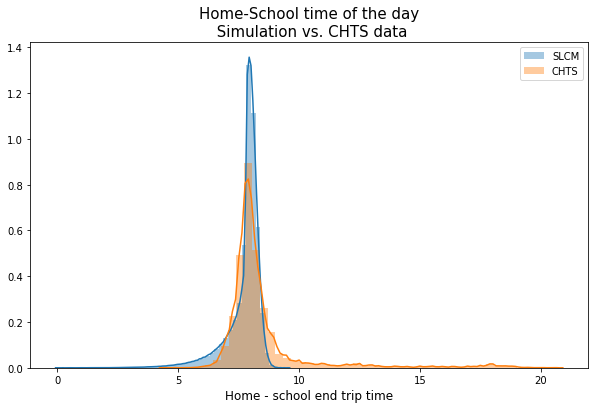

In [265]:
arrivals = persons.HS_ET.dropna()

#Plotting distance distribution
plt.figure(figsize=(10, 6))
sns.distplot(arrivals_mod, label= "SLCM")
sns.distplot(trips_final.HS_trip_ET, label = "CHTS")
plt.xlabel('Home - school end trip time', fontsize=12)
plt.title('Home-School time of the day\n Simulation vs. CHTS data', fontsize=15)

plt.legend();

In [275]:
departures = persons.SH_ST.dropna()
departues_mod = [24 if x > 24 else x for x in departures]

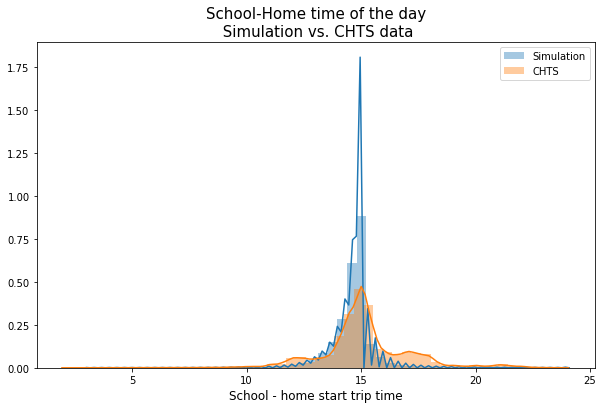

In [289]:
#Plotting distance distribution
plt.figure(figsize=(10, 6))
sns.distplot(departues_mod, label= "Simulation")
sns.distplot(trips_final.SH_trip_ST, label = "CHTS")
plt.xlabel('School - home start trip time', fontsize=12)
plt.title('School-Home time of the day\n Simulation vs. CHTS data', fontsize=15)

plt.legend();

In [291]:
skims

,from_zone_id,to_zone_id,dist
0,1,1,193.1208
1,1,2,386.2416
2,1,3,708.1096
3,1,4,659.8294
4,1,5,1094.3512
5,1,6,1561.0598
6,1,7,1577.1532
7,1,8,1850.7410
8,1,9,2526.6638
9,1,10,2558.8506


In [293]:
p_dist = persons.merge(skims, how = 'left', 
              left_on = ['zone_id_home','zone_id_school'], 
              right_on = ['from_zone_id', 'to_zone_id'])

In [298]:
p_dist.columns

Index(['member_id', 'age', 'primary_commute_mode', 'relate', 'edu', 'sex',
       'hours', 'hispanic', 'earning', 'race_id', 'student', 'work_at_home',
       'worker', 'household_id', 'school_id', 'zone_id_school',
       'TOD_school_arrival', 'TOD_school_departure', 'HS_ET', 'SH_ST',
       'school_mode_choice', 'node_id_small', 'node_id_walk', 'no_higher_ed',
       'age_under_45', 'zone_id_home', 'lessGED', 'GED', 'somebach', 'Assoc',
       'Bach', 'female', 'white', 'minority', 'age_16less25', 'age_0_5',
       'age_5_12', 'age_12_15', 'age_15_18', 'black', 'asian', 'sex_SMC',
       'race_white', 'race_african_american', 'race_indian/alaska',
       'race_asian', 'race_hawaii/pacific', 'race_other', 'race_2+races',
       'children', 'age_0_15', 'age_16_17', 'age_18_25', 'age_26_40',
       'age_41_60', 'age_60', 'worker_student', 'non_worker_non_student',
       'from_zone_id', 'to_zone_id', 'dist'],
      dtype='object')

In [302]:
p_dist = p_dist[['dist', 'school_mode_choice']].dropna()

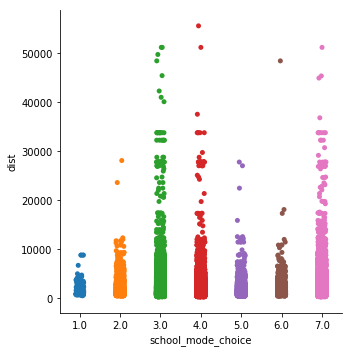

In [304]:
sns.catplot(x="school_mode_choice", y="dist", data=p_dist);

In [305]:
p_dist.school_mode_choice.value_counts()

7.0    71554
3.0    61605
4.0    35177
5.0     2866
2.0     2078
6.0     2066
1.0      149
Name: school_mode_choice, dtype: int64

In [307]:
persons.school_mode_choice.dropna()

person_id
446        4.0
448        4.0
509        3.0
510        3.0
514        3.0
515        3.0
519        3.0
520        3.0
524        3.0
525        3.0
530        3.0
535        3.0
540        3.0
545        3.0
550        3.0
555        3.0
560        3.0
565        3.0
570        3.0
575        3.0
576        3.0
577        3.0
578        3.0
585        3.0
586        3.0
587        3.0
588        3.0
595        3.0
596        3.0
597        3.0
          ... 
6570869    2.0
6570872    7.0
6570873    2.0
6570876    7.0
6570877    5.0
6570958    3.0
6570963    3.0
6571034    7.0
6571037    7.0
6571040    7.0
6571332    7.0
6571370    6.0
6571371    7.0
6571372    3.0
6571373    2.0
6571384    7.0
6571394    7.0
6571395    7.0
6571408    7.0
6571409    7.0
6571410    7.0
6571413    7.0
6571414    7.0
6571415    7.0
6571418    7.0
6571419    7.0
6571420    7.0
6571459    3.0
6571463    3.0
6571480    7.0
Name: school_mode_choice, Length: 1109985, dtype: float64